# Self defined model

In [3]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

from sklearn.metrics import mean_squared_error,mean_absolute_error
from prophet import Prophet

import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from functions_nico.nico_preprocessing import load_data, merge_oil, merge_ex_rate, get_oil_euro
from functions_nico.nico_models import baseline_model, print_model, split_data,prophet_model

/Users/nicoschreiber/Desktop/Neue_Fische/Python/FuelProphet/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
# Load data
df = load_data("../data/fueldata/wertheim_23-25.parquet") # Load fuel data
df = merge_oil(df)                                        # Include oil data
df = merge_ex_rate(df)                                    # Include exchange rates
get_oil_euro(df)                                          # Calculate oil price in euro

# Reduce data
df = df[df["datetime"] >= pd.to_datetime("2025-04-01")]
df = df[df["station_uuid"] == "fb0f8030-c1eb-4df1-9410-054eea7422ad"]

In [65]:
# Initialization

# Number of predictions (288 is one day)
pred_num = 288*2

# Model Parameters
a1 = 0.15
a2 = 0.08
a3 = 0.06
a4 = 0.04
a5 = 0.02
a6 = 0.55
a7 = 0.1

# a1 = 0.05
# a2 = 0.01
# a3 = 0.01
# a4 = 0.01
# a5 = 0.01
# a6 = 0.9
# a7 = 0.01

In [66]:
def predict(value,a1,a2,a3,a4,a5,a6,a7):
	new_value = a1*value[-1] + a2*value[-2] + a3*value[-3] + a4*value[-4] + a5*value[-5] + a6*value[-288] + a7*value[-(288*7)]
	return new_value

In [67]:
train,test = split_data(df,interval=("days",pred_num/288))
train_array = np.array(train[["e5"]])

In [68]:
def predict_value(value,a1,a2,a3,a4,a5,a6,a7,num_predictions):

    predictions = []

    for iter in range(num_predictions):
        new_value = predict(value,a1,a2,a3,a4,a5,a6,a7)
        predictions.append(float(new_value))
        value = np.append(value,new_value)

    return np.array(predictions)

In [69]:
# Predict values
predictions = predict_value(train_array,a1,a2,a3,a4,a5,a6,a7,pred_num)

In [70]:
df_pred = pd.concat([pd.DataFrame(df[-pred_num:].datetime).reset_index(drop=True),
                     pd.DataFrame(predictions, columns=["e5"]).reset_index(drop=True)],
                    axis=1)
df_pred.columns = ["datetime","e5"]

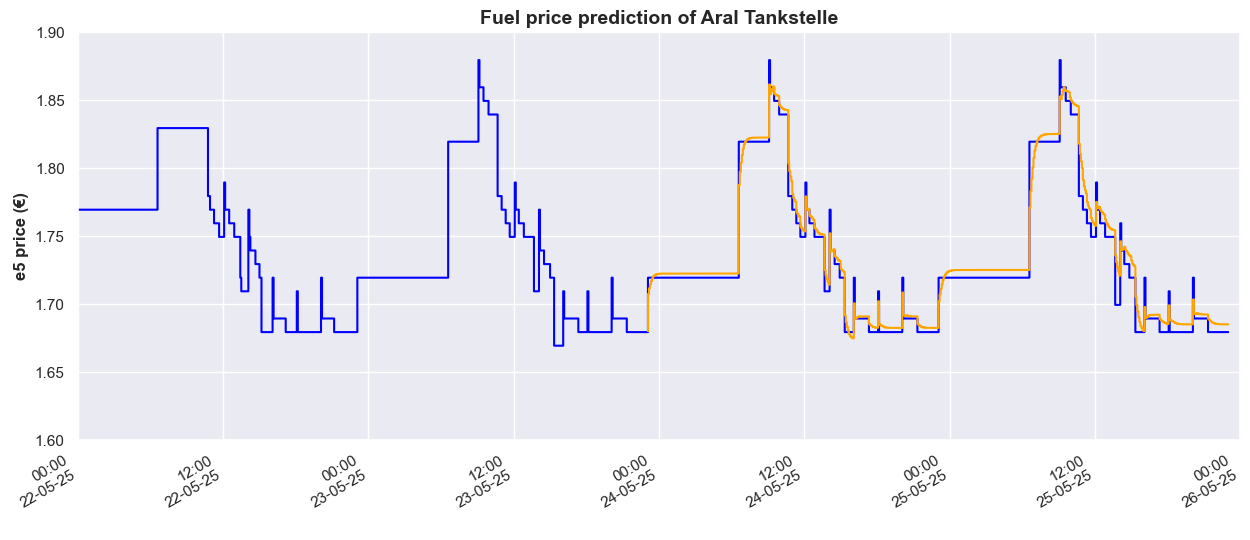

RMSE: 0.008
MAE: 0.006


In [71]:
# Print model results
print_model(df,df_pred,xlim=("2025-05-22","2025-05-26"),ylim=(1.6,1.9))

### Optimize parameters

In [34]:
def  cal_cost(b, X, y):

    n = len(y)
    
    predictions = X.dot(b)
    cost = 1/(2*n) * np.sum(np.square(predictions-y))
    return cost

def  cal_cost2(b, X, y):

    n = len(y)
    
    predictions = X.dot(b)
    cost = 1/(n) * np.sum(np.abs(predictions-y))
    return cost

In [35]:
def gradient_descent(X, y, b, learning_rate=0.01, iterations=10000):

    n = len(y)
    cost_history = np.zeros(iterations)
    b_history = np.zeros((iterations,len(b)))
    
    for it in range(iterations):
        
        prediction = np.dot(X,b)
        
        b = b - learning_rate * (1/n) * (X.T.dot((prediction - y)))
        b_history[it,:] = b.T
        cost_history[it]  = cal_cost(b, X, y)
        
    return b, cost_history, b_history

In [36]:
# Prepare X, y and b

# b
b = np.array([a1,a2,a3,a4,a5,a6,a7])

# X
X = np.full((len(train), len(b)), np.nan)

for obs in range(len(X)):
    if obs >= (288*7):
        X[obs,0] = train["e5"].iloc[(obs-1)]
        X[obs,1] = train["e5"].iloc[(obs-2)]
        X[obs,2] = train["e5"].iloc[(obs-3)]
        X[obs,3] = train["e5"].iloc[(obs-4)]
        X[obs,4] = train["e5"].iloc[(obs-5)]
        X[obs,5] = train["e5"].iloc[(obs-288)]
        X[obs,6] = train["e5"].iloc[(obs-(288*7))]

X = X[~np.isnan(X).any(axis=1)]

# y
y = train["e5"].iloc[-len(X):]



In [37]:
# Calculate best parameters
# b, cost_history, b_history = gradient_descent(X, y, b, learning_rate=0.09, iterations=10000)

In [38]:
from scipy.optimize import minimize

res = minimize(lambda b: cal_cost2(b, X, y), b)
b_opt = res.x

In [39]:
a1 = b[0]
a2 = b[1]
a3 = b[2]
a4 = b[3]
a5 = b[4]
a6 = b[5]
a7 = b[6]

In [40]:
print(b)

[0.05 0.01 0.01 0.01 0.01 0.9  0.01]


In [41]:
print(b_opt)

[ 9.99999661e-01  6.65276931e-07  2.54475621e-07 -2.19763949e-07
 -1.73600396e-07  1.43813877e-07 -3.36496167e-07]


In [54]:
b = b_opt.round(2)

In [56]:
a1 = b[0]
a2 = b[1]
a3 = b[2]
a4 = b[3]
a5 = b[4]
a6 = b[5]
a7 = b[6]

In [57]:
# fig,ax = plt.subplots(figsize=(10,8))
# ax.set_ylabel('J$(b)$')
# ax.set_xlabel('Iterations')
# ax.plot(range(10000), cost_history[:10000], 'b.')

In [58]:
# Predict values
predictions = predict_value(train_array,a1,a2,a3,a4,a5,a6,a7,pred_num)

In [59]:
df_pred = pd.concat([pd.DataFrame(df[-pred_num:].datetime).reset_index(drop=True),
                     pd.DataFrame(predictions, columns=["e5"]).reset_index(drop=True)],
                    axis=1)
df_pred.columns = ["datetime","e5"]

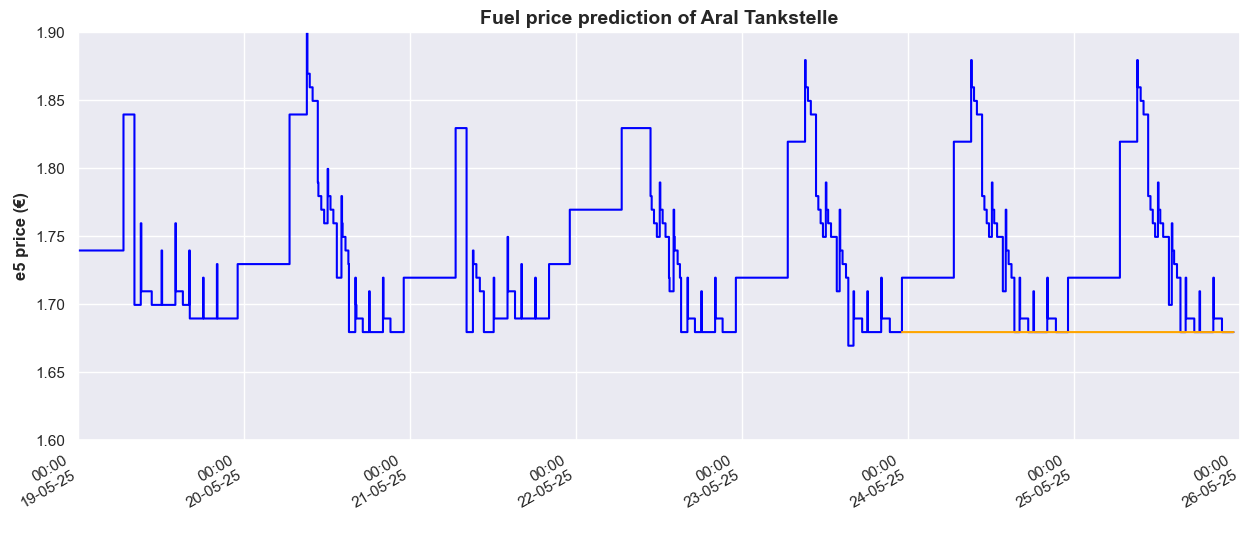

RMSE: 0.074
MAE: 0.053


In [60]:
# Print model results
print_model(df,df_pred,xlim=("2025-05-19","2025-05-26"),ylim=(1.6,1.9))